# Finite Element Demo

This notebook provides a walkthrough of a finite element method (FEM) implementation for solving an ODE boundary value problem.

Adapted from: ***An Introduction to the Finte Element Method*** by **J. N. Reddy**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad_vec

### General Problem


A wide range of engineering problems can be descibed by the following differential equation.

$$
-\frac{d}{dx}\left(a\, \frac{du}{dx}\right) + cu - q = 0
$$

| Problem    | u (Primary Variable) | a | q (Source Term) | Q (Secondary Variable) |
| -------- | ------- | ------- | ------- | ------- |
| Transverse Deflection of a Cable |  Deflection  | Tension | Distributed Load | Axial Load |
| Heat Transfer  |  Temperature  | Thermal Conductivity | Heat Generation | Heat |
| Electrostatics  |  Potential  | Dielectric Constant | Charge Density | Electric Flux |


### Specific Problem

In this example we will attempt to solve the following ODE

\begin{equation}
-\frac{d^2\,u}{d\,x^2} - u + x^2 = 0, \quad x\in[0,1]
\end{equation}

which relates to the following coeficients with regards to the general case

$$
a = 1, \quad c = 1, \quad q = - x^2
$$


In [2]:
a =  1
c = -1
q = lambda x : - np.power(x, 2)

### Analytical Solution

The analytical soluion to [Equation 1](#mjx-eqn-eq1) is

\begin{equation}\tag{2}
u^\star(x) = \frac{\sin(x) + 2 \sin(1 - x)}{\sin(1)} + x^2 - 2
\end{equation}



In [3]:
# Analytical Solution
def u_star(x):
    return (np.sin(x) + 2 * np.sin(1 - x)) / np.sin(1) + (x**2) - 2 

### 1. Discretisation & Domain

This demo will use elements with three nodes, at which a solution $u^e_j$ to the ODE will be evaluated.

![Element Diagram](../images/Element.svg)
<!-- <center>
<img src="../images/Element.svg" alt="drawing" width="30%"/>
</center> -->

Solutions at other points within the subdoman of the node $\Omega^e$ are approximated as a weighted sum of the j known nodal values, where the weights are from some interpolation function. 

\begin{equation} \tag{3}
u(x) \approx \sum^j_{i=1} \psi^e_j(x) \, u^e_j 
\end{equation}

In this example we will be using the second order Legrangian interpolation functions.

$$
\psi^e_i(x) = \alpha^e_i + \beta^e_i\,x + \gamma^e_i \, x^2
$$

Which in the local co-ordinates of our element are

$$
\psi^e_1(\bar{x}) = \left(1 - \frac{\bar{x}}{h_e}\right) \left(1-\frac{2\bar{x}}{h_e}\right), \quad \psi^e_2(\bar{x}) = \,\, 4\frac{\bar{x}}{h_e} \left(1 - \frac{\bar{x}}{h_e}\right), \quad \psi^e_3(\bar{x}) = -\frac{\bar{x}}{h_e} \left(1-\frac{2\bar{x}}{h_e}\right)
$$

<!-- \begin{align*}\tag{4}
\psi^e_1(\bar{x}) &= \left(1 - \frac{\bar{x}}{h_e}\right) \left(1-\frac{2\bar{x}}{h_e}\right), \\
\psi^e_2(\bar{x}) &= \,\, 4\frac{\bar{x}}{h_e} \left(1 - \frac{\bar{x}}{h_e}\right)\\
\psi^e_3(\bar{x}) &= -\frac{\bar{x}}{h_e} \left(1-\frac{2\bar{x}}{h_e}\right)\\
\end{align*} -->

In [4]:
# Length of Domain
L = 1

# E Quadratic Elements
E = 5

# 2E + 1 Nodes
N = (2*E) + 1

In [5]:
# Local Eelement Domain Length 
he = L / E

In [6]:
# Interpolation functions
def psi(x_bar):

    psi1 = lambda x : (1 - x) * (1 - 2 * x) 
    psi2 = lambda x : 4 * x * (1 - x)
    psi3 = lambda x : - x * (1 - 2 * x)

    return np.array([psi1(x_bar), psi2(x_bar), psi3(x_bar)])

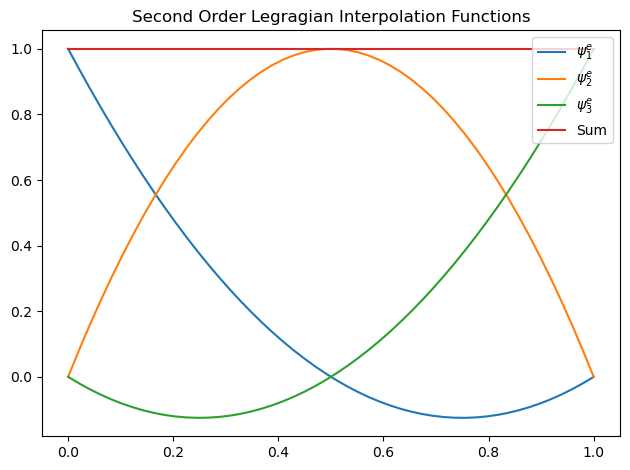

In [7]:
# Plot interpolation functions

x = np.linspace(0,1)

plt.plot(x, psi(x).T, label = [r"$\psi^e_1$", r"$\psi^e_2$", r"$\psi^e_3$"])
plt.plot(x, np.sum(psi(x), axis=0), label = "Sum")
plt.legend(loc="upper right")
plt.title("Second Order Legragian Interpolation Functions")
plt.tight_layout()
plt.show()

### 2. Variational Form

Using the steps outlined last week, we can derive the variational form of our ODE

$$
\int^{x_B}_{x_A} \left( a \frac{dw}{dx} \frac{du}{dx} + cwu -wq\right)\, dx - \left[wa\frac{du}{dx}\right]^{x_A}_{x_B} = 0
$$

which can be posed as the variational problem 

\begin{equation} \tag{5}
    0 = B(w,u) - l(w)
\end{equation}

where 

\begin{align*}
B(w,u) &= \int^{x_B}_{x_A} \left( a \frac{dw}{dx} \frac{du}{dx} + cwu\right)\, dx\\
l(w)   &= \int^{x_B}_{x_A} wq\,dx + \left[wa\frac{du}{dx}\right]^{x_A}_{x_B}
\end{align*}

The terms are split in a way that

1. The functional $B(w,u)$ bilinear and symetric in $w$ and $u$
2. The functional $l(w)$ is lienar in $u$

These conditions are sufficient to ensure that the solutions to [equation 5](#mjx-eqn-eq5) and [equation 6](#mjx-eqn-eq6) are identical.


\begin{equation} \tag{6}
    0 = \frac{1}{2}B(u,u) - l(u)
\end{equation}


### 3. Element Solution

To determine a solution for a given element with $n$ nodes, we undergo substitution of [equation 3](#mjx-eqn-eq3) into [equation 6](#mjx-eq6-eq6), resulting in a set of $n$ many equations for each element which can be written in matrix form as

\begin{equation}\tag{6}
    [K^e]\{u^e\} = \{f^e\} + \{Q^e\}
\end{equation}

where 

\begin{equation*}
K^e_{ij} = B(\psi^e_i, \psi^e_j) = \int^{x_B}_{x_A} \left(a \frac{\psi^e_i}{dx} \frac{\psi^e_j}{dx} + c\psi^e_i\psi^e_j \right)\,dx, \quad f^e_i = l(\psi^e_i) =  \int^{x_B}_{x_A} q \,\psi^e_i \, dx 
\end{equation*}


For each element:
- $[K^e]$ is the coefficient matrix (or the stiffness matrix in structural mechanics).
- $\{f^e\}$ is the source vector (or force vector)
- $\{u^e\}$ are the primary nodal degrees of freedom
- $\{Q^e\}$ are the secondary nodal degrees of freedom

At this stage $[K^e]$ and $\{f^e\}$ can be evaluated for a given element and problem.

In the case of our problem, $[K_e]$ is constant across elements, whereas $\{f^e\}$ is not

\begin{equation*}
[K^e] = \frac{a_e}{3h_e} \begin{bmatrix}
7 & -8 & 1 \\
-8 & 16 & -8 \\
1 & -8 & 7 
\end{bmatrix} + \frac{c_e h_e}{30} \begin{bmatrix}
4  & 2  & -1 \\
2  & 16 & 2 \\
-1 & 2  & 4 \end{bmatrix}
\end{equation*}

In [8]:
# [Ke] / Element Coefficient Matrix 
Ke = ((a / (3*he))  * np.array([[7, -8,  1], [-8, 16, -8], [ 1, -8, 7]]) 
   +  (c * he / 30) * np.array([[4,  2, -1], [ 2, 16,  2], [-1,  2, 4]]) 
)

\begin{equation*}
\{f^e\} = \int^{x_B}_{x_A} q \,\psi^e_i \,dx
\end{equation*}

In [9]:
# {fe} / Element Source Vector
def Fe(i, k):
    
    # Integral Bounds
    xa, xb = i * he / 2, k * he / 2

    # X bar 
    x_bar = (x - xa) / (xb - xa)

    # Function to integrate 
    func = lambda x : q(x) * psi(x_bar)

    return quad_vec(func, xa, xb)[0]

### 4. Global Solution Construction

To solve the problem over the full domain, we must 

1. Assemble the elemental solutions into a single set of global lienar equations
2. Apply the boundary conditions
3. Solve the resulting linear equations

![Element Connectivity Diagram](../images/ElementConnnect.svg)
<!-- <center>
<img src="../images/ElementConnnect.svg" alt="drawing" width="50%"/>
</center> -->

The elemental equations are arranged to ensure

* Continuity of primary variables 
* Balance of Secondary variables

or

* $
u^e_n = u^{e+1}_1
$

* $
Q^e_n + Q^{e+1}_{1} = \begin{cases} 
      0 & \text{if no external point source}\\
      Q_0 &  \text{if an external point source}\\
 \end{cases}
$

The connectivity matrix $B$ describes which nodes belong to which elements. The terms of the element coeficient matrix and source vector can be added to the gloabl solution matrix to ensure the continuity and balancing of the appropriate variables occurs.

In [10]:
# Initialise Empty Global Solution
K = np.zeros((N, N))
F = np.zeros((N,))
U = np.full ((N,), np.nan)

In [11]:
# Connectivity Matrix
B = np.arange(0, E)
B = 2 * B[:, None] + np.array([0, 1, 2])

In [12]:
display(B)

array([[ 0,  1,  2],
       [ 2,  3,  4],
       [ 4,  5,  6],
       [ 6,  7,  8],
       [ 8,  9, 10]])

In [13]:
# Fill Nodal and Primary Variable Coeficient Matrix
for (i,j,k) in B:
    F[[i,j,k]] += Fe(i,k)
    K[np.ix_([i,j,k],[i,j,k])] += Ke

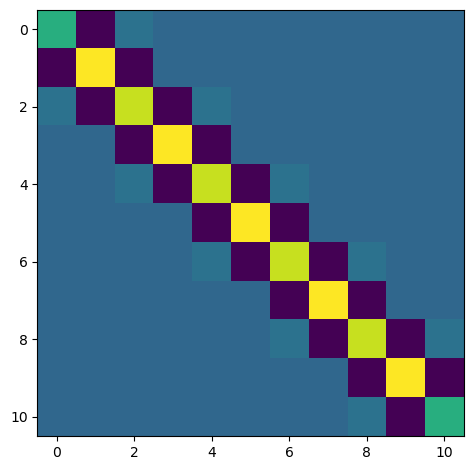

In [14]:
plt.imshow(K)
plt.tight_layout()
plt.show()

### 5. Global Solution Evaluation

The set of equations describing the global solution can be written as

$$
\begin{bmatrix}
[K^{11}] & [K^{12}] \\
[K^{21}] & [K^{22}] 
\end{bmatrix} \left\{\begin{matrix}
\{U^1\} \\
\{U^2\} 
\end{matrix} \right\} = \left\{\begin{matrix}
\{F^1\} \\
\{F^2\} 
\end{matrix} \right\}
$$

where 

* $\{U^1\}$ is the column of known primary variables
* $\{F^2\}$ is the column of known primary variables
* $\{U^2\}$ is the column of unknown primary variables
* $\{F^1\}$ is the column of unknown primary variables


the unknown primary variables are then

$$
\{U^2\} = [K^{22}]^{-1} \left( \{F^2\} - [K^{21}]\{U^1\} \right) 
$$


In [15]:
# Apply Boundary Conditions 
U[[0,-1]] = -0 

In [16]:
# Identify known primary variabes
m = ~np.isnan(U)

In [17]:
K_22 = K[np.ix_(~m, ~m)]
F_2  = F[~m]
K_21 = K[np.ix_(~m, m)]
U_1  = U[m]

In [18]:
# Solve & Avoid Matrix Inversion
U[~m] = np.linalg.solve(K_22, F_2 - np.matmul(K_21, U_1))

### 6. Interpolation of Solutions

The solution can then be aprroximated at any point in the domain with equation [equation 3](#mjx-eqn-eq3) $ u(x) \approx \sum^j_{i=1} \psi^e_j(x) \, u^e_j $


In [19]:
def interpolate(x):

    xa = B[:,0][:, np.newaxis] * he/2
    xb = B[:,2][:, np.newaxis] * he/2

    x_bar = (x - xa)/(xb-xa)

    m = (x_bar <= 1) & (x_bar >= 0)

    psi_ = psi(x_bar)[:,m]

    u = np.stack([U[B] for _ in x]).T[:,m]

    u = np.repeat(U[np.newaxis, B] , x.shape[0], axis=0).T[:,m]

    u = np.sum(u * psi_, axis=0)

    return u

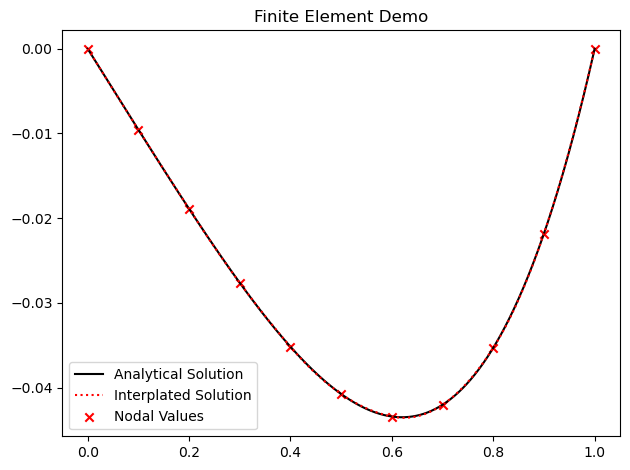

In [20]:
x = np.linspace(0, 1, 10_000)

plt.title("Finite Element Demo")
plt.plot(x, u_star(x), 'k', label="Analytical Solution")
plt.plot(x, interpolate(x), ':r', label="Interplated Solution" )
plt.scatter([he/2 * i for i in range(len(U))], U,marker='x',color='r', label='Nodal Values')
plt.legend()
plt.tight_layout()
plt.show(
)